# Investment with Adjustment Costs (Numba)


We consider an investment problem with adjustment costs with inverse demand
curve

$$    P_t = a_0 - a_1 Y_t + Z_t, $$

where $P_t$ is price, $Y_t$ is output and $Z_t$ is a demand shock.

We assume that $Z_t$ is a discretized AR(1) process.

Current profits are 

$$ P_t Y_t - c Y_t - gamma (Y_{t+1} - Y_t)^2 $$

The firm maximizes present value of expected discounted profits.  The state is

$$    X_t = (Y_t, Z_t) $$

The right-hand side of the Bellman equation is 

$$   B(y, z, y′) = r(y, z, y′) + β Σ_z′ v(y′, z′) Q(z, z′). $$

where 

$$    r(y, z, y′) := (a_0 - a_1 * y + z - c) y - γ * (y′ - y)^2 $$

In [3]:
from collections import namedtuple
import numpy as np
import quantecon as qe
from numba import njit, prange, int32
import matplotlib.pyplot as plt

In [4]:
def successive_approx(T,                     # Operator (callable)
                      x_0,                   # Initial condition
                      tolerance=1e-6,        # Error tolerance
                      max_iter=10_000,       # Max iteration bound
                      print_step=25,         # Print at multiples
                      verbose=False):        
    x = x_0
    error = tolerance + 1
    k = 1
    while error > tolerance and k <= max_iter:
        x_new = T(x)
        error = np.max(np.abs(x_new - x))
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    elif verbose:
        print(f"Terminated successfully in {k} iterations.")
    return x

## Primitives and operators

In [5]:
# A namedtuple definition for storing parameters and grids
Model = namedtuple("Model", 
                   ("β", "a_0", "a_1", "γ", "c",
                    "y_size", "z_size", "y_grid", "z_grid", "Q"))

def create_investment_model(
        r=0.01,                              # Interest rate
        a_0=10.0, a_1=1.0,                   # Demand parameters
        γ=25.0, c=1.0,                       # Adjustment and unit cost 
        y_min=0.0, y_max=20.0, y_size=100,   # Grid for output
        ρ=0.9, ν=1.0,                        # AR(1) parameters
        z_size=150):                         # Grid size for shock
    """
    A function that takes in parameters and returns an instance of Model that
    contains data for the investment problem.
    """
    β = 1/(1+r) 
    y_grid = np.linspace(y_min, y_max, y_size)  
    mc = qe.tauchen(ρ, ν, n=z_size)
    z_grid, Q = mc.state_values, mc.P

    model = Model(β=β, a_0=a_0, a_1=a_1, γ=γ, c=c,
                  y_size=y_size, z_size=z_size,
                  y_grid=y_grid, z_grid=z_grid, Q=Q)
    return model

In [6]:
@njit
def B(i, j, ip, v, model):
    """
    The right-hand side of the Bellman equation with candidate value v and
    arguments y[i], z[j], yp[ip].

    """
    β, a_0, a_1, γ, c, y_size, z_size, y_grid, z_grid, Q = model
    y, z, yp = y_grid[i], z_grid[j], y_grid[ip]
    r = (a_0 - a_1 * y + z - c) * y - γ * (yp - y)**2
    return r + β * np.dot(v[ip, :], Q[j, :]) 

In [7]:
@njit(parallel=True)
def T_σ(v, σ, model):
    "The policy operator."
    v_new = np.empty_like(v)
    for i in prange(model.y_size):
        for j in range(model.z_size):
            v_new[i, j] = B(i, j, σ[i, j], v, model)
    return v_new


@njit(parallel=True)
def T(v, model):
    "The Bellman operator."
    β, a_0, a_1, γ, c, y_size, z_size, y_grid, z_grid, Q = model
    v_new = np.empty_like(v)
    for i in prange(y_size):
        for j in range(z_size):
            max_val = -np.inf
            for ip in range(y_size):
                val = B(i, j, ip, v, model)
                if val > max_val:
                    max_val = val
            v_new[i, j] = max_val
    return v_new


@njit(parallel=True)
def get_greedy(v, model):
    "Compute a v-greedy policy."
    β, a_0, a_1, γ, c, y_size, z_size, y_grid, z_grid, Q = model
    σ = np.empty_like(v, dtype=int32)
    for i in prange(y_size):
        for j in range(z_size):
            max_val = -np.inf
            for ip in range(y_size):
                val = B(i, j, ip, v, model)
                if val > max_val:
                    max_val = val
                    argmax_index = ip
            σ[i, j] = argmax_index
    return σ

In [8]:
@njit(parallel=True)
def get_value(σ, model):
    "Get the value v_σ of policy σ."
    # Unpack and set up
    β, a_0, a_1, γ, c, y_size, z_size, y_grid, z_grid, Q = model
    ny, nz = len(y_grid), len(z_grid)
    n = ny * nz
    # Function to extract (i, j) from m = i + (j-1)*ny"
    def single_to_multi(m):
        i = m // nz
        j = m - nz * i
        return i, j
    # Allocate and create single index versions of P_σ and r_σ
    P_σ = np.zeros((n, n))
    r_σ = np.zeros(n)
    for m in prange(n):
        i, j = single_to_multi(m)
        y, z, yp = y_grid[i], z_grid[j], y_grid[σ[i, j]]
        r_σ[m] = (a_0 - a_1 * y + z - c) * y - γ * (yp - y)**2
        for mp in range(n):
            ip, jp = single_to_multi(mp)
            if ip == σ[i, j]:
                P_σ[m, mp] = Q[j, jp]
    # Solve for the value of σ 
    v_σ = np.linalg.solve(np.identity(n) - β * P_σ, r_σ)
    # Return as multi-index array
    return np.reshape(v_σ, (ny, nz))

In [9]:
# == Solvers == #

def value_iteration(model, tol=1e-5):
    "Implements VFI."
    vz = np.zeros((len(model.y_grid), len(model.z_grid)))
    v_star = successive_approx(lambda v: T(v, model), vz, tolerance=tol)
    return get_greedy(v_star, model)

def policy_iteration(model):
    "Howard policy iteration routine."
    ny, nz = len(model.y_grid), len(model.z_grid)
    σ = np.ones((ny, nz), dtype=int)
    i, error = 0, 1.0
    while error > 0:
        v_σ = get_value(σ, model)
        σ_new = get_greedy(v_σ, model)
        error = np.max(np.abs(σ_new - σ))
        σ = σ_new
        i = i + 1
        print(f"Concluded loop {i} with error {error}.")
    return σ

def optimistic_policy_iteration(model, tol=1e-5, m=100):
    "Implements the OPI routine."
    v = np.zeros((len(model.y_grid), len(model.z_grid)))
    error = tol + 1
    while error > tol:
        last_v = v
        σ = get_greedy(v, model)
        for _ in range(m):
            v = T_σ(v, σ, model)
        error = np.max(np.abs(v - last_v))
    return get_greedy(v, model)

## Simple timing tests

In [10]:
model = create_investment_model()

In [11]:
print("Starting HPI.")
qe.tic()
out = policy_iteration(model)
elapsed = qe.toc()
print(out)
print(f"HPI completed in {elapsed} seconds.")

Starting HPI.
Concluded loop 1 with error 49.
Concluded loop 2 with error 26.
Concluded loop 3 with error 17.
Concluded loop 4 with error 10.
Concluded loop 5 with error 6.
Concluded loop 6 with error 4.
Concluded loop 7 with error 2.
Concluded loop 8 with error 1.
Concluded loop 9 with error 1.
Concluded loop 10 with error 1.
Concluded loop 11 with error 0.
TOC: Elapsed: 0:03:22.46
[[ 2  2  2 ...  6  6  6]
 [ 3  3  3 ...  7  7  7]
 [ 4  4  4 ...  7  7  7]
 ...
 [82 82 82 ... 86 86 86]
 [83 83 83 ... 86 86 86]
 [84 84 84 ... 87 87 87]]
HPI completed in 202.46469736099243 seconds.


In [12]:
print("Starting VFI.")
qe.tic()
out = value_iteration(model)
elapsed = qe.toc()
print(out)
print(f"VFI completed in {elapsed} seconds.")

Starting VFI.
TOC: Elapsed: 0:00:23.29
[[ 2  2  2 ...  6  6  6]
 [ 3  3  3 ...  7  7  7]
 [ 4  4  4 ...  7  7  7]
 ...
 [82 82 82 ... 86 86 86]
 [83 83 83 ... 86 86 86]
 [84 84 84 ... 87 87 87]]
VFI completed in 23.29140043258667 seconds.


In [13]:
print("Starting OPI.")
qe.tic()
out = optimistic_policy_iteration(model, m=5)
elapsed = qe.toc()
print(out)
print(f"OPI completed in {elapsed} seconds.")

Starting OPI.
TOC: Elapsed: 0:00:6.25
[[ 2  2  2 ...  6  6  6]
 [ 3  3  3 ...  7  7  7]
 [ 4  4  4 ...  7  7  7]
 ...
 [82 82 82 ... 86 86 86]
 [83 83 83 ... 86 86 86]
 [84 84 84 ... 87 87 87]]
OPI completed in 6.254746913909912 seconds.


## Plots 

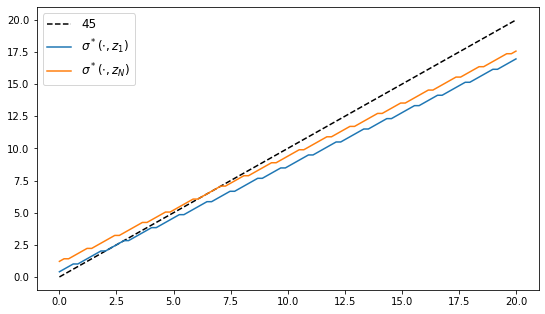

In [14]:
fontsize = 12
model = create_investment_model()
β, a_0, a_1, γ, c, y_size, z_size, y_grid, z_grid, Q = model
σ_star = optimistic_policy_iteration(model)
fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(y_grid, y_grid, "k--", label="45")
ax.plot(y_grid, y_grid[σ_star[:, 1]], label="$\\sigma^*(\cdot, z_1)$")
ax.plot(y_grid, y_grid[σ_star[:, -1]], label="$\\sigma^*(\cdot, z_N)$")
ax.legend(fontsize=fontsize)
plt.show()

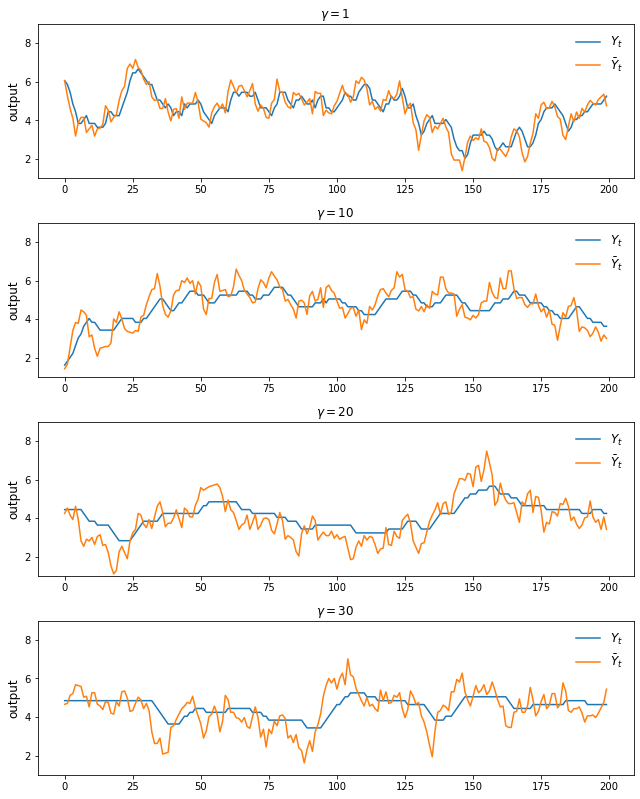

In [17]:
ts_length = 200
fig, axes = plt.subplots(4, 1, figsize=(9, 11.2))

for (ax, γ) in zip(axes, (1, 10, 20, 30)):
    model = create_investment_model(γ=γ)
    β, a_0, a_1, γ, c, y_size, z_size, y_grid, z_grid, Q = model
    σ_star = optimistic_policy_iteration(model)
    mc = qe.MarkovChain(Q, z_grid)

    z_sim_idx = mc.simulate_indices(ts_length)
    z_sim = z_grid[z_sim_idx]
    y_sim_idx = np.empty(ts_length, dtype=int)
    y_1 = (a_0 - c + z_sim[0]) / (2 * a_1)
    y_sim_idx[0] = np.searchsorted(y_grid, y_1)
    for t in range(ts_length-1):
        y_sim_idx[t+1] = σ_star[y_sim_idx[t], z_sim_idx[t]]
    y_sim = y_grid[y_sim_idx]
    y_bar_sim = (a_0 - c + z_sim) / (2 * a_1)

    ax.plot(range(ts_length), y_sim, label="$Y_t$")
    ax.plot(range(ts_length), y_bar_sim, label="$\\bar Y_t$")
    ax.legend(fontsize=fontsize, frameon=False, loc="upper right")
    ax.set_ylabel("output", fontsize=fontsize)
    ax.set_ylim(1, 9)
    ax.set_title(f"$\gamma = {γ}$", fontsize=fontsize)

fig.tight_layout()
plt.show()

Running Howard policy iteration.
Concluded loop 1 with error 49.
Concluded loop 2 with error 26.
Concluded loop 3 with error 17.
Concluded loop 4 with error 10.
Concluded loop 5 with error 6.
Concluded loop 6 with error 4.
Concluded loop 7 with error 2.
Concluded loop 8 with error 1.
Concluded loop 9 with error 1.
Concluded loop 10 with error 1.
Concluded loop 11 with error 0.
TOC: Elapsed: 0:03:29.10
PI completed in 209.1031777858734 seconds.
Running value function iteration.
TOC: Elapsed: 0:00:23.43
VFI completed in 23.432738065719604 seconds.
Running optimistic policy iteration with m=5.
TOC: Elapsed: 0:00:5.47
OPI with m=5 completed in 5.479588270187378 seconds.
Running optimistic policy iteration with m=105.
TOC: Elapsed: 0:00:0.90
OPI with m=105 completed in 0.901252269744873 seconds.
Running optimistic policy iteration with m=205.
TOC: Elapsed: 0:00:0.94
OPI with m=205 completed in 0.9491403102874756 seconds.
Running optimistic policy iteration with m=305.
TOC: Elapsed: 0:00:1.1

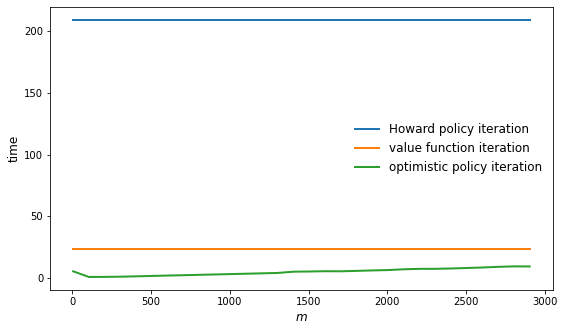

In [16]:
m_vals = range(5, 3000, 100)
model = create_investment_model()
print("Running Howard policy iteration.")
qe.tic()
σ_pi = policy_iteration(model)
pi_time = qe.toc()
print(f"PI completed in {pi_time} seconds.")
print("Running value function iteration.")
qe.tic()
σ_vfi = value_iteration(model, tol=1e-5)
vfi_time = qe.toc()
print(f"VFI completed in {vfi_time} seconds.")
assert np.all(σ_vfi == σ_pi), "Warning: VFI policy deviated from true policy."
opi_times = []
for m in m_vals:
    print(f"Running optimistic policy iteration with m={m}.")
    qe.tic()
    σ_opi = optimistic_policy_iteration(model, m=m, tol=1e-5)
    opi_time = qe.toc()
    print(f"OPI with m={m} completed in {opi_time} seconds.")
    assert np.all(σ_opi == σ_pi), "Warning: OPI policy deviated."
    opi_times.append(opi_time)
fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(m_vals, np.full(len(m_vals), pi_time), 
        lw=2, label="Howard policy iteration")
ax.plot(m_vals, np.full(len(m_vals), vfi_time), 
        lw=2, label="value function iteration")
ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
ax.legend(fontsize=fontsize, frameon=False)
ax.set_xlabel("$m$", fontsize=fontsize)
ax.set_ylabel("time", fontsize=fontsize)
plt.show()